### Import Packages and Load Data

In [50]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score, mean_squared_error, roc_curve, auc
from sklearn.linear_model import LogisticRegression, LinearRegression
import seaborn as sns
from scipy import stats
import warnings
from pathlib import Path
warnings.filterwarnings('ignore')

#### Load Real and Synthetic Data
---

In [51]:
def load_datasets(dataset_name: str, synthetic_root: Path, real_root: Path) -> dict:
    """
    Load real and synthetic datasets for a given dataset name.
    
    Parameters
    ----------
    dataset_name : str
        Base dataset name (e.g., 'diabetes', 'stroke', 'cirrhosis').
    synthetic_root : Path
        Path to the folder containing the synthetic CSV files.
    real_root : Path
        Path to the folder containing the processed real CSV files.
    
    Returns
    -------
    dict
        Dictionary with model names as keys ('Real', 'CTGAN', etc.)
        and loaded DataFrames as values.
    """
    
    datasets = {}

    # Load real dataset (from processed folder with _train suffix)
    real_file = real_root / f"{dataset_name}_train.csv"
    if real_file.exists():
        datasets["Real"] = pd.read_csv(real_file)
    else:
        print(f"Real dataset not found: {real_file}")

    # Synthetic models
    models = ["CTGAN", "RTF", "CTABGAN", "tabddpm", "GReaT", "TVAE"]
    
    for model in models:
        file_path = synthetic_root / f"{dataset_name}_{model}.csv"
        if file_path.exists():
            datasets[model] = pd.read_csv(file_path)
        else:
            print(f" File not found: {file_path}")
    
    return datasets


In [52]:
synthetic_root = Path("/home/jovyan/DataGen/Github/data/sample_synthetic/")
real_root      = Path("/home/jovyan/DataGen/Github/data/processed/")

diabetes_datasets  = load_datasets("diabetes", synthetic_root, real_root)
stroke_datasets    = load_datasets("stroke", synthetic_root, real_root)
cirrhosis_datasets = load_datasets("cirrhosis", synthetic_root, real_root)

In [53]:
#datasets=diabetes_datasets.copy()
#datasets=stroke_datasets.copy()
datasets=cirrhosis_datasets.copy()

### Evaluating Number of Duplicated Within the Synthetic Dataset and between Real and Synthetic Datasets

In [6]:
def ensure_consistent_dtypes(datasets):
    for df in datasets.values():
        for col in df.columns:
            if df[col].dtype == 'float64' and (df[col] % 1 == 0).all():
                df[col] = df[col].astype('int64')

def count_duplicates(datasets):
    duplicate_counts = {}
    for name, df in datasets.items():
        df_rounded = df.round(6)
        duplicate_counts[name] = df_rounded.duplicated(keep=False).sum() // 2
    return duplicate_counts

def count_duplicates_with_real(datasets):
    real_data = datasets['Real']
    duplicate_with_real = {}
    for name, df in datasets.items():
        if name != 'Real':
            common_cols = df.columns.intersection(real_data.columns)
            df_copy = df[common_cols].copy()
            real_data_copy = real_data[common_cols].copy()
            df_copy = df_copy.astype(real_data_copy.dtypes)
            duplicate_with_real[name] = df_copy.merge(real_data_copy, how='inner').shape[0]
    return duplicate_with_real

In [37]:
ensure_consistent_dtypes(datasets)
duplicate_counts = count_duplicates(datasets)
duplicate_with_real = count_duplicates_with_real(datasets)

print("\nNumber of duplicate rows within each dataset:")
for name, count in duplicate_counts.items():
    print(f"{name}: {count}")

print("\nNumber of duplicate rows between synthetic datasets and 'Real':")
for name, count in duplicate_with_real.items():
    print(f"{name}: {count}")


Number of duplicate rows within each dataset:
Real: 2341
CTGAN: 285
RTF: 2254
CTABGAN: 9
tabddpm: 2234
GReaT: 10512
TVAE: 315

Number of duplicate rows between synthetic datasets and 'Real':
CTGAN: 194
RTF: 5931
CTABGAN: 12
tabddpm: 6186
GReaT: 17388
TVAE: 1644


## Combined MIA AIA Plotting
----

#### Parameters for AIA Attacks

In [56]:
def get_eval_config(dataset_name: str):
    """
    Return target_columns and categorical_cols for MIA/AIA based on dataset.
    Accepts 'diabetes', 'stroke', or 'cirrhosis' (case-insensitive).
    """
    name = dataset_name.strip().lower()

    configs = {
        "stroke": {
            "target_columns": ["work_type", "Residence_type", "stroke"],
            "categorical_cols": ["work_type", "stroke", "gender", "smoking_status",
                                 "ever_married", "Residence_type", "hypertension", "heart_disease"],
        },
        "diabetes": {
            "target_columns": ["smoking_history", "hypertension", "heart_disease", "age"],
            "categorical_cols": ["gender", "hypertension", "heart_disease", "smoking_history", "diabetes"],
        },
        "cirrhosis": {
            "target_columns": ["Stage", "Status", "Bilirubin", "Edema"],
            "categorical_cols": ["Status", "Drug", "Sex", "Ascites", "Hepatomegaly", "Spiders", "Edema", "Stage"],
        },
    }
#"Cholesterol",
    if name not in configs:
        raise ValueError(f"Unknown dataset '{dataset_name}'. Choose from: {list(configs.keys())}")

    return configs[name]["target_columns"], configs[name]["categorical_cols"]


In [57]:
#target_columns, categorical_cols = get_eval_config("diabetes")
# or
#target_columns, categorical_cols = get_eval_config("stroke")
# or
target_columns, categorical_cols = get_eval_config("cirrhosis")

In [58]:
# ==================== MIA CODE ====================

def run_mia_robust(real_df, synth_df,n_iterations=5, balance_datasets=True):
    """
    Robust Membership Inference Attack implementation
    """
    
    # Balance dataset sizes if requested
    if balance_datasets:
        min_size = min(len(real_df), len(synth_df))
        real_df = real_df.sample(n=min_size, random_state=42).reset_index(drop=True)
        synth_df = synth_df.sample(n=min_size, random_state=42).reset_index(drop=True)
    
    # Identify categorical columns
    categorical_cols = [
        col for col in real_df.select_dtypes(include=['object', 'category']).columns
        if real_df[col].nunique() <= 20
    ]

    # One-hot encode categorical variables
    if categorical_cols:
        combined = pd.concat([real_df, synth_df], axis=0, ignore_index=True)
        encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
        encoded = encoder.fit_transform(combined[categorical_cols])
        encoded_cols = encoder.get_feature_names_out(categorical_cols)

        real_encoded = pd.DataFrame(encoded[:len(real_df)], columns=encoded_cols)
        synth_encoded = pd.DataFrame(encoded[len(real_df):], columns=encoded_cols)

        real_processed = real_df.drop(columns=categorical_cols).reset_index(drop=True).join(real_encoded)
        synth_processed = synth_df.drop(columns=categorical_cols).reset_index(drop=True).join(synth_encoded)
    else:
        real_processed = real_df.copy()
        synth_processed = synth_df.copy()

    # Create labels (1 for real/member, 0 for synthetic/non-member)
    y_member = np.ones(len(real_processed))
    y_nonmember = np.zeros(len(synth_processed))
    
    X = pd.concat([real_processed, synth_processed], axis=0, ignore_index=True)
    y = np.concatenate([y_member, y_nonmember])
    
    # Handle missing values
    X = X.fillna(X.median(numeric_only=True))
    for col in X.columns:
        if X[col].dtype == 'object':
            X[col] = X[col].fillna(X[col].mode().iloc[0] if not X[col].mode().empty else 'Unknown')

    # Run multiple iterations
    auc_scores = []
    roc_curves = []
    
    for seed in range(n_iterations):
        try:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.3, random_state=seed, stratify=y
            )
            
            clf = RandomForestClassifier(random_state=seed, n_estimators=100)
            clf.fit(X_train, y_train)
            
            probs = clf.predict_proba(X_test)[:, 1]
            fpr, tpr, _ = roc_curve(y_test, probs)
            roc_auc = auc(fpr, tpr)
            
            auc_scores.append(roc_auc)
            roc_curves.append((fpr, tpr))
            
        except Exception as e:
            print(f"Error in MIA iteration {seed}: {e}")
            continue
    
    if not auc_scores:
        return None
    
    return {
        'mean_auc': np.mean(auc_scores),
        'std_auc': np.std(auc_scores),
        'all_scores': auc_scores,
        'roc_curves': roc_curves,
        'n_features': X.shape[1],
        'n_samples': len(X)
    }

def evaluate_mia_all_models(datasets):
    """Evaluate MIA for all synthetic models"""
    
    if "Real" not in datasets:
        raise ValueError("datasets must contain 'Real' key")
    
    real_df = datasets["Real"].copy()
    results = {}
    
    print("Running Membership Inference Attacks...")
    print("=" * 50)
    
    # Evaluate each synthetic model
    for name, synth_df in datasets.items():
        if name == "Real":
            continue
            
        print(f"Evaluating MIA for {name}...", end=" ")
        
        try:
            mia_result = run_mia_robust(real_df, synth_df.copy())
            
            if mia_result:
                results[name] = mia_result
                print(f"AUC = {mia_result['mean_auc']:.3f} ± {mia_result['std_auc']:.3f}")
            else:
                print("Failed")
                
        except Exception as e:
            print(f"Error: {e}")
    
    return results

# ==================== AIA CODE ====================

def clean_and_prepare_data(df, target_col, categorical_cols):
    """Clean and prepare data for AIA"""
    df = df.copy()
    
    # Handle missing values in target
    if df[target_col].isnull().sum() > 0:
        if target_col in categorical_cols:
            mode_val = df[target_col].mode()
            if len(mode_val) > 0:
                df[target_col] = df[target_col].fillna(mode_val[0])
        else:
            df[target_col] = df[target_col].fillna(df[target_col].median())
    
    # Remove rows where target is still missing
    df = df.dropna(subset=[target_col])
    
    # Clean malformed values
    mask = df[target_col].astype(str).str.contains(r'[\[\]]', na=False)
    if mask.any():
        df = df[~mask]
    
    return df

def prepare_features(X_train, X_test, categorical_cols):
    """Prepare features with proper encoding and scaling"""
    
    existing_cat_cols = [col for col in categorical_cols if col in X_train.columns]
    
    if existing_cat_cols:
        X_train_encoded = pd.get_dummies(X_train, columns=existing_cat_cols, drop_first=True, dummy_na=True)
        X_test_encoded = pd.get_dummies(X_test, columns=existing_cat_cols, drop_first=True, dummy_na=True)
        
        train_cols = set(X_train_encoded.columns)
        test_cols = set(X_test_encoded.columns)
        
        for col in train_cols - test_cols:
            X_test_encoded[col] = 0
        for col in test_cols - train_cols:
            X_train_encoded[col] = 0
            
        common_cols = sorted(list(train_cols | test_cols))
        X_train_final = X_train_encoded[common_cols]
        X_test_final = X_test_encoded[common_cols]
    else:
        X_train_final = X_train.copy()
        X_test_final = X_test.copy()
    
    # Fill remaining missing values
    for col in X_train_final.columns:
        if X_train_final[col].dtype in ['float64', 'int64']:
            median_val = X_train_final[col].median()
            X_train_final[col] = X_train_final[col].fillna(median_val)
            X_test_final[col] = X_test_final[col].fillna(median_val)
        else:
            mode_val = X_train_final[col].mode()
            fill_val = mode_val[0] if len(mode_val) > 0 else 'Unknown'
            X_train_final[col] = X_train_final[col].fillna(fill_val)
            X_test_final[col] = X_test_final[col].fillna(fill_val)
    
    return X_train_final, X_test_final

def run_aia_single_target(real_df, synth_df, target_col, categorical_cols, n_iterations=5):
    """Run AIA for a single target attribute"""
    
    is_categorical = target_col in categorical_cols
    task_type = "Classification" if is_categorical else "Regression"
    
    try:
        real_clean = clean_and_prepare_data(real_df, target_col, categorical_cols)
        synth_clean = clean_and_prepare_data(synth_df, target_col, categorical_cols)
        
        if len(real_clean) < 50 or len(synth_clean) < 50:
            return {'success': False, 'error': 'Insufficient samples', 'task_type': task_type}
        
        feature_cols = [col for col in real_clean.columns if col != target_col]
        
        X_synth = synth_clean[feature_cols]
        y_synth = synth_clean[target_col]
        X_real = real_clean[feature_cols]
        y_real = real_clean[target_col]
        
        common_features = list(set(X_synth.columns) & set(X_real.columns))
        if len(common_features) < 2:
            return {'success': False, 'error': 'Insufficient features', 'task_type': task_type}
        
        X_synth = X_synth[common_features]
        X_real = X_real[common_features]
        
        scores = []
        
        for iteration in range(n_iterations):
            try:
                X_train, X_val, y_train, y_val = train_test_split(
                    X_synth, y_synth, test_size=0.2, random_state=iteration
                )
                
                X_train_prep, X_real_prep = prepare_features(X_train, X_real, categorical_cols)
                
                if is_categorical:
                    le = LabelEncoder()
                    all_labels = pd.concat([y_train, y_val, y_real]).dropna().unique()
                    le.fit(all_labels)
                    
                    y_train_enc = le.transform(y_train)
                    y_real_enc = le.transform(y_real)
                    
                    if len(np.unique(y_train_enc)) < 2:
                        continue
                    
                    if len(np.unique(y_train_enc)) == 2:
                        clf = LogisticRegression(random_state=iteration, max_iter=1000)
                        scaler = StandardScaler()
                        X_train_scaled = scaler.fit_transform(X_train_prep)
                        X_real_scaled = scaler.transform(X_real_prep)
                        
                        clf.fit(X_train_scaled, y_train_enc)
                        y_pred_proba = clf.predict_proba(X_real_scaled)
                        score = roc_auc_score(y_real_enc, y_pred_proba[:, 1])
                    else:
                        clf = RandomForestClassifier(random_state=iteration, n_estimators=100)
                        clf.fit(X_train_prep, y_train_enc)
                        y_pred_proba = clf.predict_proba(X_real_prep)
                        score = roc_auc_score(y_real_enc, y_pred_proba, multi_class='ovr', average='macro')
                else:
                    reg = RandomForestRegressor(random_state=iteration, n_estimators=100)
                    reg.fit(X_train_prep, y_train)
                    y_pred = reg.predict(X_real_prep)
                    score = max(0, r2_score(y_real, y_pred))
                
                scores.append(score)
                
            except Exception as e:
                continue
        
        if len(scores) == 0:
            return {'success': False, 'error': 'All iterations failed', 'task_type': task_type}
        
        return {
            'success': True,
            'mean_score': np.mean(scores),
            'std_score': np.std(scores),
            'all_scores': scores,
            'task_type': task_type,
            'n_iterations': len(scores)
        }
        
    except Exception as e:
        return {'success': False, 'error': str(e), 'task_type': task_type}

def run_aia_comprehensive(datasets, target_columns, categorical_cols):
    """Run comprehensive AIA evaluation"""
    
    if "Real" not in datasets:
        raise ValueError("datasets must contain 'Real' key")
    
    real_df = datasets["Real"].copy()
    results = []
    
    print("\nRunning Attribute Inference Attacks...")
    print("=" * 50)
    
    for model_name, synth_df in datasets.items():
        if model_name == "Real":
            continue
            
        print(f"Evaluating {model_name}...")
        model_scores = []
        
        for target in target_columns:
            if target not in real_df.columns or target not in synth_df.columns:
                print(f" Skipping {target} - not found in both datasets")
                continue
                
            print(f"  Attacking {target}...", end=" ")
            
            result = run_aia_single_target(real_df, synth_df, target, categorical_cols)
            
            if result['success']:
                results.append({
                    'Synthetic_Model': model_name,
                    'Target_Attribute': target,
                    'Task_Type': result['task_type'],
                    'Mean_Score': round(result['mean_score'], 3),
                    'Std_Score': round(result['std_score'], 3),
                    'N_Iterations': result['n_iterations']
                })
                model_scores.append(result['mean_score'])
                print(f"✓ Score: {result['mean_score']:.3f}")
            else:
                print(f"✗ {result['error']}")
        
        if model_scores:
            avg_score = np.mean(model_scores)
            print(f"  Model Average: {avg_score:.3f}")
    
    return pd.DataFrame(results)

# ==================== COMBINED PLOTTING ====================

def plot_combined_results(mia_results, aia_results, model_order=None):
    """Plot MIA ROC curves and AIA bar chart side by side"""
    
    if model_order is None:
        model_order = ["TVAE", "CTGAN", "CTABGAN", "RTF", "GReaT", "tabddpm"]
    
    # Prepare AIA data
    numeric_aia = aia_results[aia_results['Mean_Score'] != 'Error'].copy()
    numeric_aia['Mean_Score'] = pd.to_numeric(numeric_aia['Mean_Score'])
    numeric_aia['Std_Score'] = pd.to_numeric(numeric_aia['Std_Score'])
    
    aia_model_stats = numeric_aia.groupby('Synthetic_Model')[['Mean_Score', 'Std_Score']].mean()
    
    aia_models = []
    aia_scores = []
    aia_stds = []
    
    for model in model_order:
        if model in aia_model_stats.index:
            aia_models.append(model)
            aia_scores.append(aia_model_stats.loc[model, 'Mean_Score'])
            aia_stds.append(aia_model_stats.loc[model, 'Std_Score'])
    
    # Create side-by-side plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
    
    # Colors for consistency
    colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E', '#8B4513']
    
    # Plot MIA ROC curves (original style)
    color_map = {}
    for i, model in enumerate(model_order):
        if model in mia_results:
            color_map[model] = colors[i % len(colors)]
    
    for name, result in mia_results.items():
        if result['roc_curves']:
            
            fpr, tpr = result['roc_curves'][0]
            color = color_map.get(name, colors[0])
            ax1.plot(fpr, tpr, label=f"{name} (AUC = {result['mean_auc']:.3f})", 
                    color=color, linewidth=2)
    
    # Add random baseline to MIA plot
    ax1.plot([0, 1], [0, 1], 'k--', label="Random (AUC = 0.50)", alpha=0.7)
    
    ax1.set_title('Membership Inference Attack (MIA)', fontsize=24)
    ax1.set_xlabel('False Positive Rate', fontsize=14)
    ax1.set_ylabel('True Positive Rate', fontsize=14)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.legend(loc='lower right',fontsize=14)
    ax1.grid(alpha=0.3)
    
    # Plot AIA bar chart
    bars2 = ax2.bar(aia_models, aia_scores,
                    yerr=aia_stds, capsize=5,
                    color=colors[:len(aia_models)],
                    alpha=0.8, edgecolor='black', linewidth=0.5)
    
    ax2.set_title('Attribute Inference Attack (AIA)', fontsize=24)
    ax2.set_ylabel('Average Score (AUC-ROC & R²)', fontsize=14)
    ax2.set_xlabel('')
    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random Baseline')
    ax2.set_ylim(0.4, 1.0)
    ax2.grid(axis='y', alpha=0.3)
    ax2.tick_params(axis='x', labelsize=14)  
    ax2.legend()
    

    for bar, score in zip(bars2, aia_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{score:.3f}', ha='center', va='bottom', fontsize=12)
    
    # Rotate x-axis labels for AIA only
    ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def print_combined_summary(mia_results, aia_results):
    """Print combined summary tables"""
    
    print("\n" + "="*80)
    print("PRIVACY ATTACK EVALUATION SUMMARY")
    print("="*80)
    
    # MIA Summary Table
    print("\n📊 MEMBERSHIP INFERENCE ATTACK (MIA) RESULTS:")
    print("-" * 60)
    print(f"{'Model':<15} {'Mean AUC':<12} {'Std AUC':<12} {'Privacy Risk':<12}")
    print("-" * 60)
    
    mia_summary = []
    for name, result in mia_results.items():
        mean_auc = result['mean_auc']
        std_auc = result['std_auc']
        
        if mean_auc < 0.55:
            risk = "Low"
        elif mean_auc < 0.65:
            risk = "Medium"  
        else:
            risk = "High"
            
        print(f"{name:<15} {mean_auc:<12.3f} {std_auc:<12.3f} {risk:<12}")
        mia_summary.append({'Model': name, 'MIA_AUC': mean_auc, 'MIA_Risk': risk})
    
    # AIA Summary Table
    print(f"\n ATTRIBUTE INFERENCE ATTACK (AIA) RESULTS:")
    print("-" * 60)
    print(f"{'Model':<15} {'Mean AUC':<12} {'Std AUC':<12} {'Privacy Risk':<12}")
    print("-" * 60)
    
    # Calculate AIA averages
    numeric_aia = aia_results[aia_results['Mean_Score'] != 'Error'].copy()
    numeric_aia['Mean_Score'] = pd.to_numeric(numeric_aia['Mean_Score'])
    numeric_aia['Std_Score'] = pd.to_numeric(numeric_aia['Std_Score'])
    
    aia_model_stats = numeric_aia.groupby('Synthetic_Model')[['Mean_Score', 'Std_Score']].mean()
    aia_model_stats = aia_model_stats.sort_values('Mean_Score', ascending=False)
    
    aia_summary = []
    for model, stats in aia_model_stats.iterrows():
        mean_score = stats['Mean_Score']
        std_score = stats['Std_Score']
        
        if mean_score < 0.6:
            risk = "Low"
        elif mean_score < 0.7:
            risk = "Medium"
        else:
            risk = "High"
            
        print(f"{model:<15} {mean_score:<12.3f} {std_score:<12.3f} {risk:<12}")
        aia_summary.append({'Model': model, 'AIA_AUC': mean_score, 'AIA_Risk': risk})
    
    # Combined Risk Assessment
    print(f"\n🔒 OVERALL PRIVACY RISK RANKING:")
    print("-" * 40)
    
    # Merge summaries
    mia_df = pd.DataFrame(mia_summary)
    aia_df = pd.DataFrame(aia_summary)
    combined = pd.merge(mia_df, aia_df, on='Model', how='outer')
    combined['Combined_Score'] = (combined['MIA_AUC'].fillna(0.5) + combined['AIA_AUC'].fillna(0.5)) / 2
    combined = combined.sort_values('Combined_Score', ascending=True)
    
    for i, row in combined.iterrows():
        print(f"{row['Model']:<15} Combined Score: {row['Combined_Score']:.3f}")
    
    print(f"\n Best Privacy Protection: {combined.iloc[0]['Model']}")
    print(f"  Highest Privacy Risk: {combined.iloc[-1]['Model']}")

def run_complete_privacy_evaluation(datasets, target_columns, categorical_cols):
    """Run complete privacy evaluation with MIA and AIA"""
    
    print("Starting Comprehensive Privacy Attack Evaluation")
    print("="*60)
    
    # Run MIA evaluation
    mia_results = evaluate_mia_all_models(datasets)
    
    # Run AIA evaluation  
    aia_results = run_aia_comprehensive(datasets, target_columns, categorical_cols)
    
    # Plot combined results
    print(f"\n Generating Combined Visualization...")
    fig = plot_combined_results(mia_results, aia_results)
    print_combined_summary(mia_results, aia_results)
    
    return mia_results, aia_results, fig


## Implementation
---

Starting Comprehensive Privacy Attack Evaluation
Running Membership Inference Attacks...
Evaluating MIA for CTGAN... AUC = 0.775 ± 0.044
Evaluating MIA for RTF... AUC = 0.775 ± 0.044
Evaluating MIA for CTABGAN... AUC = 0.770 ± 0.024
Evaluating MIA for tabddpm... AUC = 0.631 ± 0.026
Evaluating MIA for GReaT... AUC = 0.488 ± 0.045
Evaluating MIA for TVAE... AUC = 0.654 ± 0.015

Running Attribute Inference Attacks...
Evaluating CTGAN...
  Attacking Stage... ✓ Score: 0.771
  Attacking Status... ✓ Score: 0.817
  Attacking Bilirubin... ✓ Score: 0.397
  Attacking Edema... ✓ Score: 0.785
  Model Average: 0.692
Evaluating RTF...
  Attacking Stage... ✓ Score: 0.771
  Attacking Status... ✓ Score: 0.817
  Attacking Bilirubin... ✓ Score: 0.397
  Attacking Edema... ✓ Score: 0.785
  Model Average: 0.692
Evaluating CTABGAN...
  Attacking Stage... ✓ Score: 0.655
  Attacking Status... ✓ Score: 0.635
  Attacking Bilirubin... ✓ Score: 0.459
  Attacking Edema... ✓ Score: 0.693
  Model Average: 0.610
Evalua

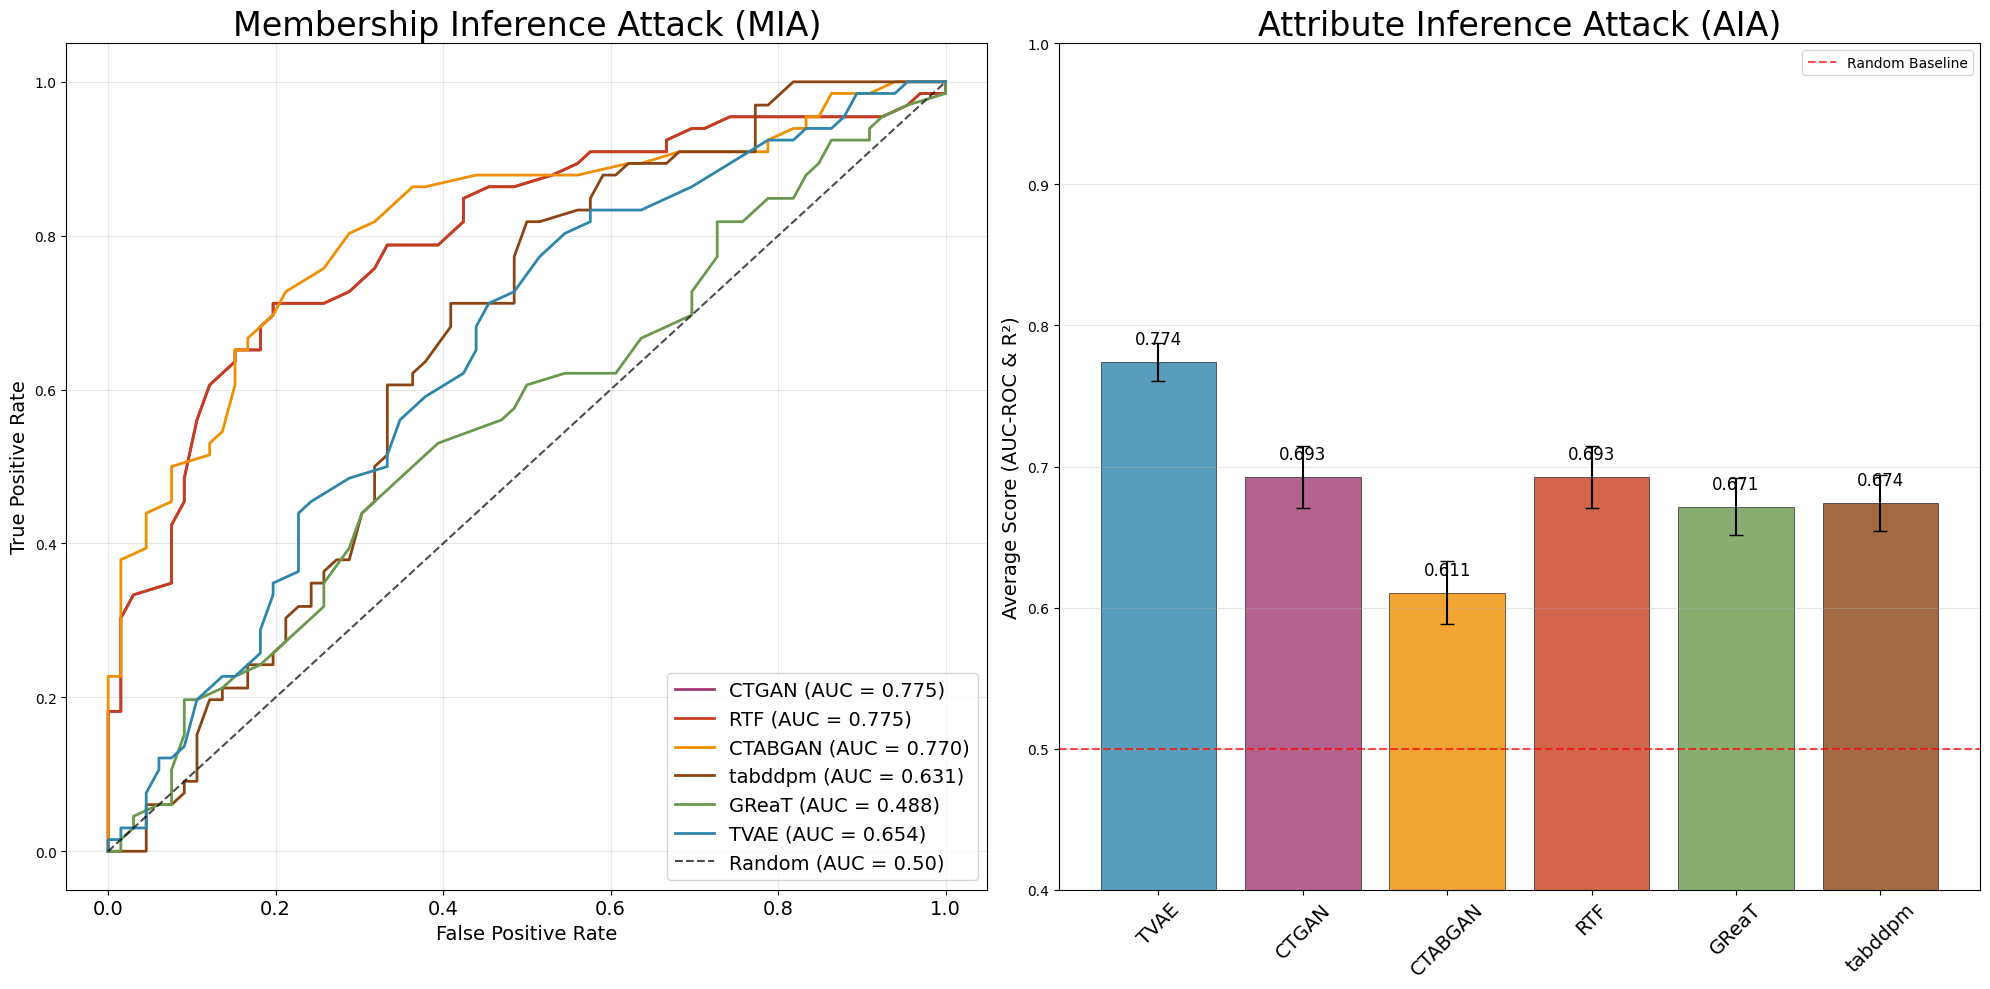


PRIVACY ATTACK EVALUATION SUMMARY

📊 MEMBERSHIP INFERENCE ATTACK (MIA) RESULTS:
------------------------------------------------------------
Model           Mean AUC     Std AUC      Privacy Risk
------------------------------------------------------------
CTGAN           0.775        0.044        High        
RTF             0.775        0.044        High        
CTABGAN         0.770        0.024        High        
tabddpm         0.631        0.026        Medium      
GReaT           0.488        0.045        Low         
TVAE            0.654        0.015        High        

 ATTRIBUTE INFERENCE ATTACK (AIA) RESULTS:
------------------------------------------------------------
Model           Mean AUC     Std AUC      Privacy Risk
------------------------------------------------------------
TVAE            0.774        0.013        High        
CTGAN           0.693        0.022        Medium      
RTF             0.693        0.022        Medium      
tabddpm         0.674     

In [59]:
mia_results, aia_results, fig = run_complete_privacy_evaluation(datasets, target_columns, categorical_cols)

# To save the plot:
fig.savefig('privacy_attacks_comparison.png', dpi=300, bbox_inches='tight')
fig.savefig('privacy_attacks_comparison.pdf', bbox_inches='tight')

### Diabetes Results

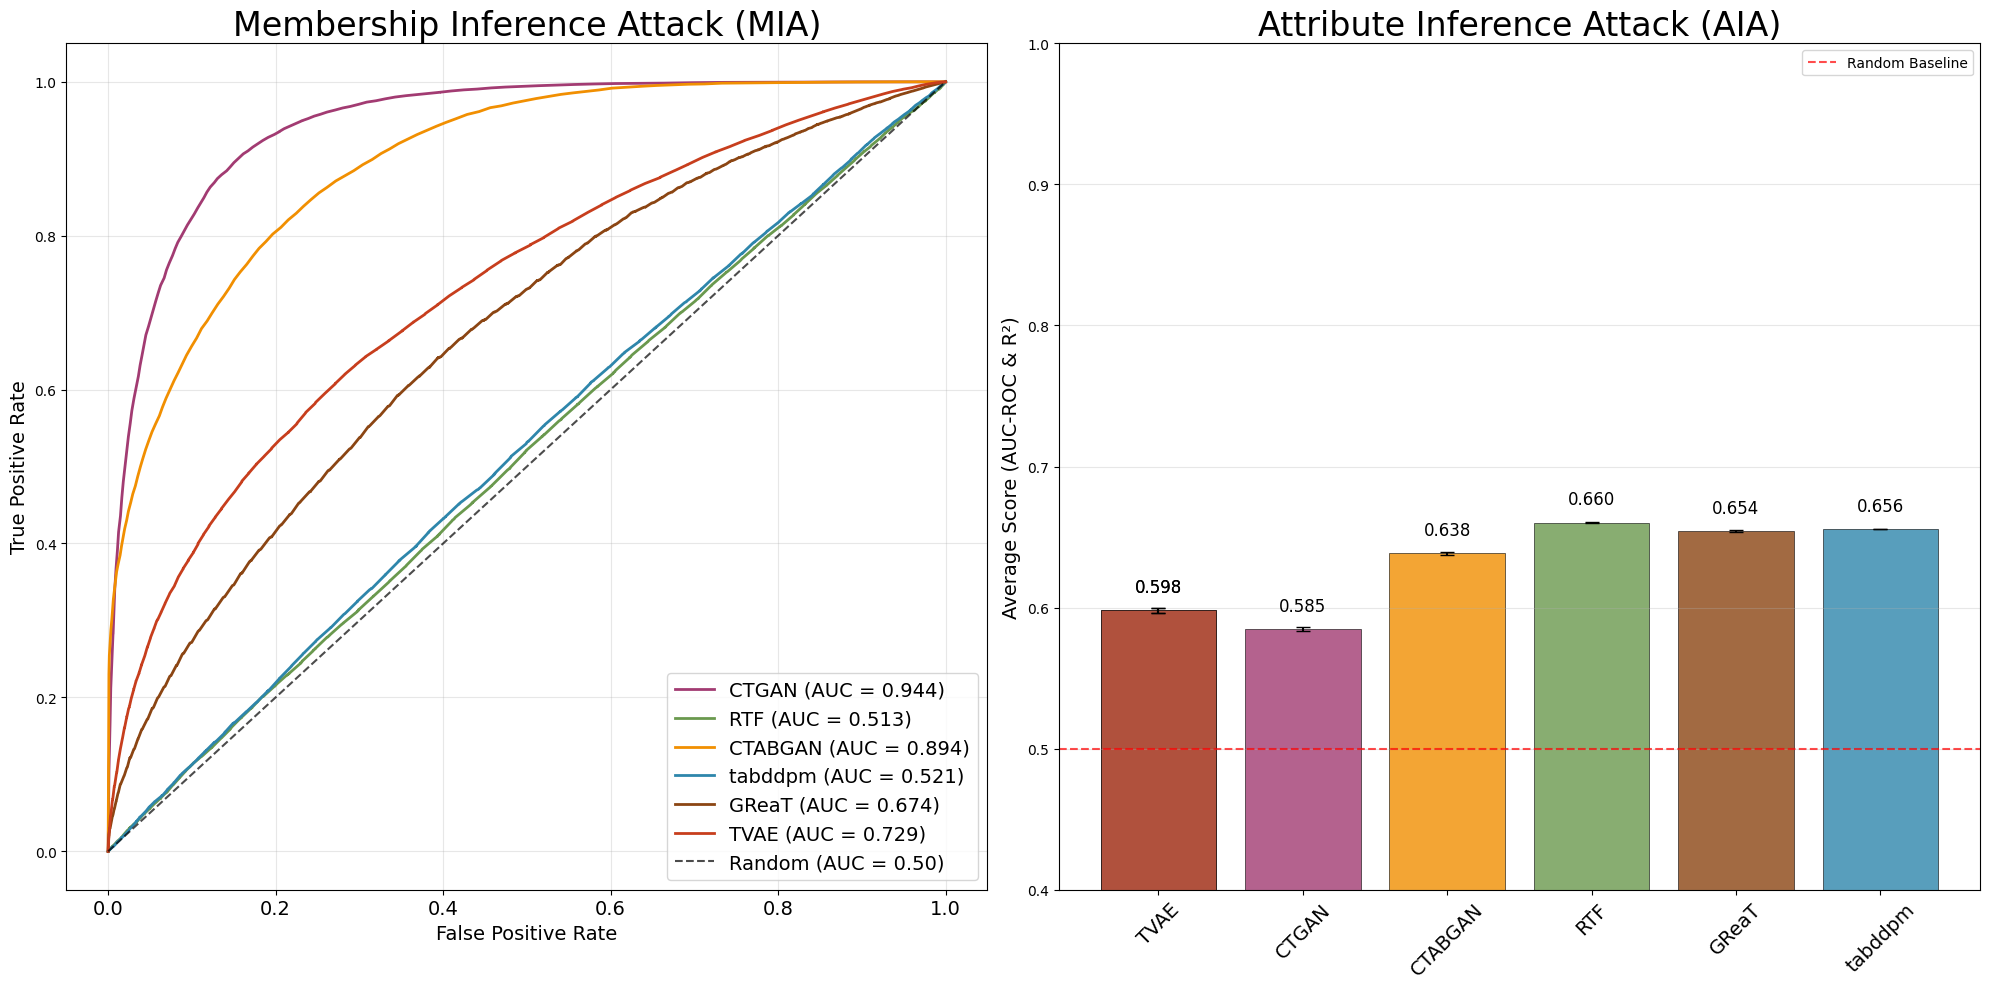

In [47]:
diabetes_fig = plot_combined_results(mia_results, aia_results, model_order=["TVAE","CTGAN","CTABGAN","TVAE","RTF","GReaT","tabddpm"])


### Stroke Results

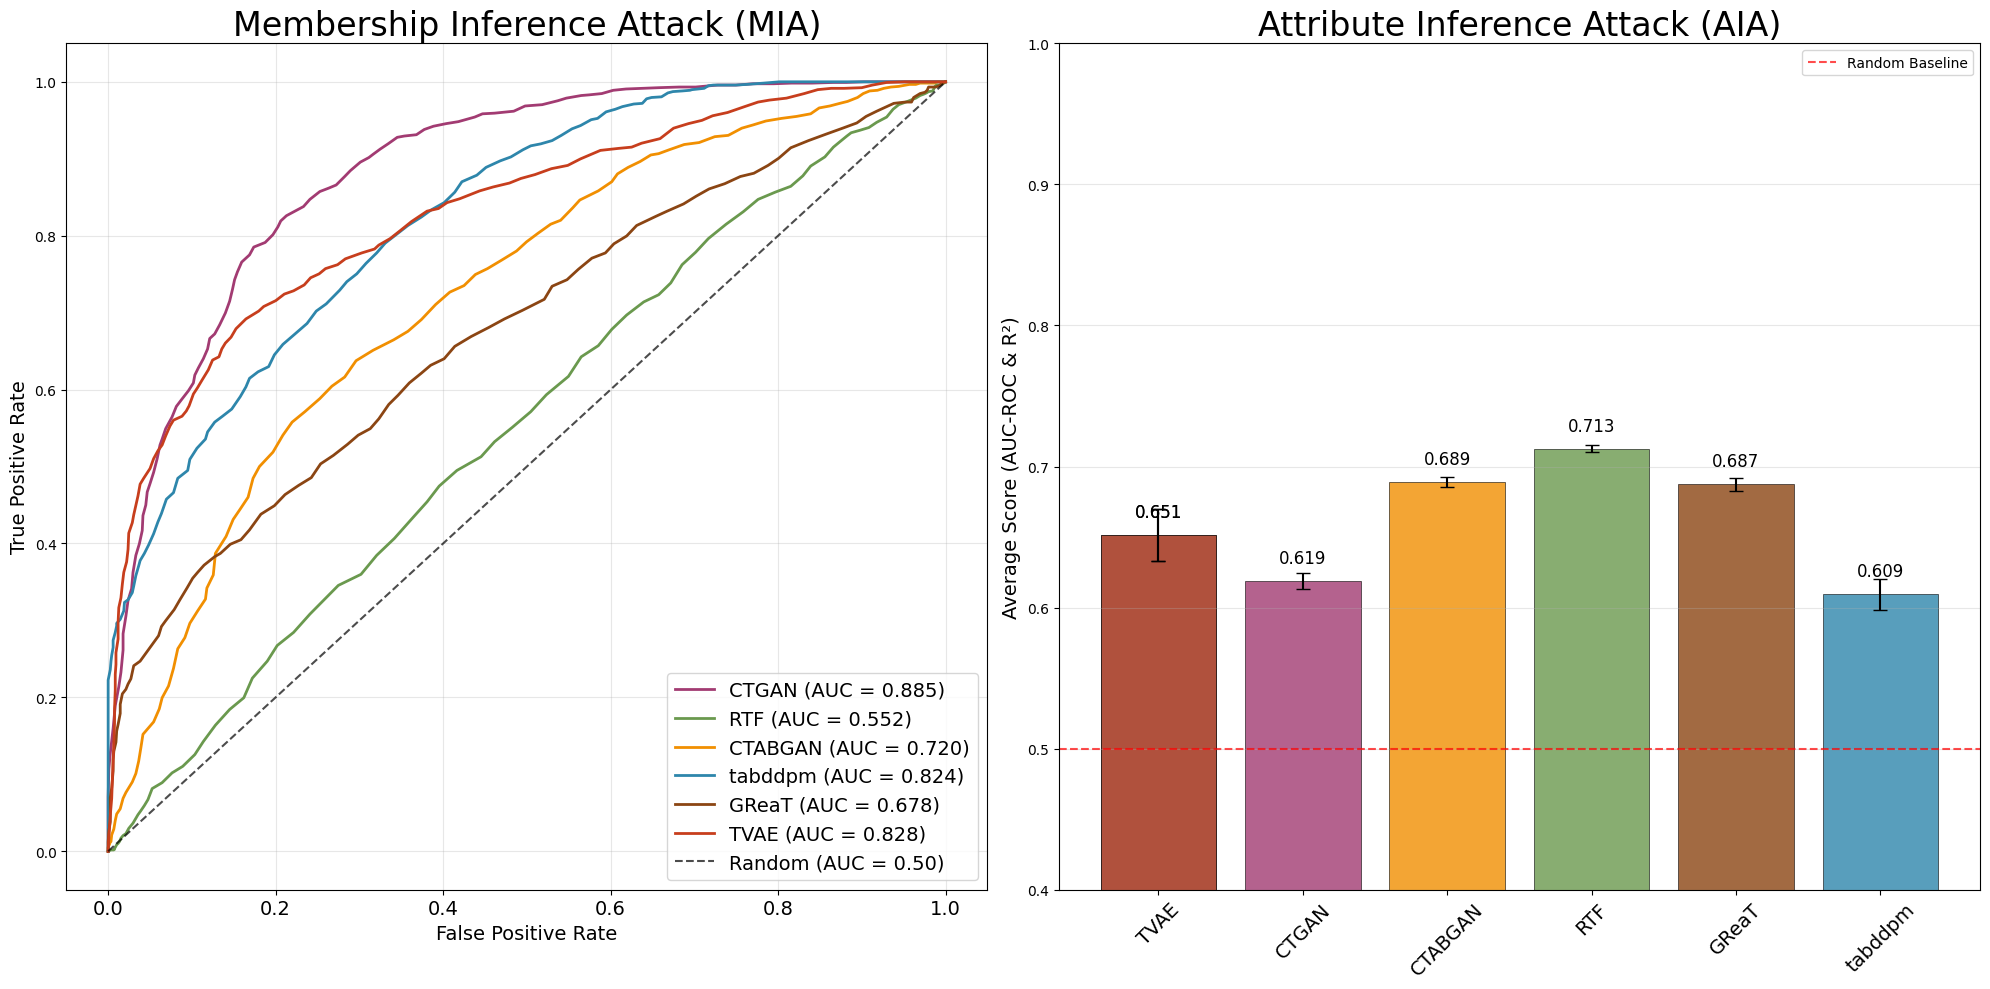

In [52]:
stroke_fig = plot_combined_results(mia_results, aia_results, model_order=["TVAE","CTGAN","CTABGAN","TVAE","RTF","GReaT","tabddpm"])

### Cirrhosis Results

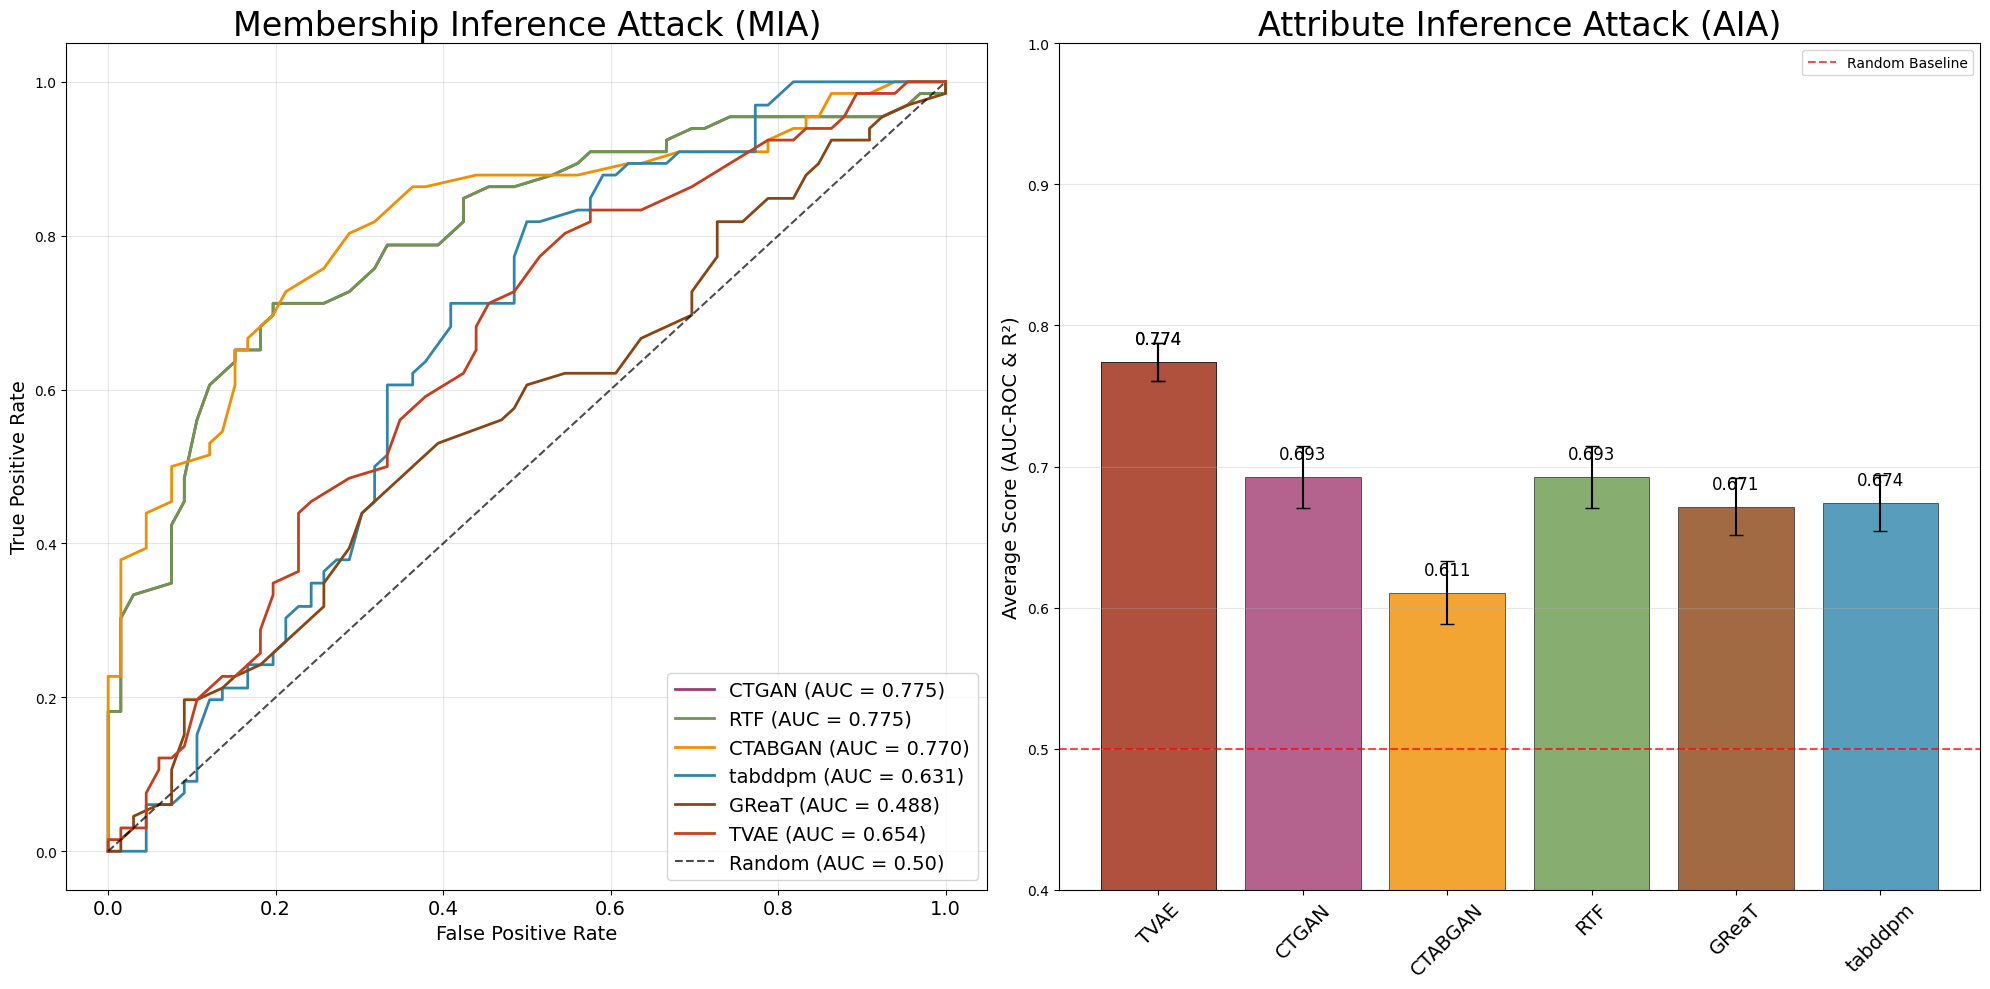

In [60]:
cirrhosis_fig = plot_combined_results(mia_results, aia_results, model_order=["TVAE","CTGAN","CTABGAN","TVAE","RTF","GReaT","tabddpm"])